In [35]:
%reset
import sys
sys.path.append("/home/aallawala/")
sys.path.append("/home/aallawala/Presidio_stage1_analysis/gen_fxns")
from myimports import *
from typing import Any
from h5py._hl.base import Empty
from numpy import ndarray

In [36]:
ptID = "RCS04"
# get metadata. 
path_string = Path("/userdata/aallawala/pain_data/stage0/%s/mood_biomarker/preproc_data" % (ptID)) 
filename = "%s_807_ieeg_wavelet.h5" % (ptID)
filepath = path_string / filename
f1 = h5py.File(name=filepath)

ch_labels = f1.attrs['ch_labels']
n_ch = ch_labels.shape[0]

freqs = f1.attrs['freqs']
n_freq = len(freqs)

In [37]:
import re
tmp = re.findall(r'\d+', str(filepath))
res = list(map(int, tmp))
fileid = res[3]

In [38]:
data_root = Path(path_string)
file_keyword = '_wavelet_mean'
dataset_name = "mean_psd"

# Function to extract numeric part from filename
def extract_number(filename):
    return int(''.join(filter(str.isdigit, filename)))

def load_h5_files(path_string, file_keyword, dataset_name):
    h5_arrays = []
    fileids = [] 
    # Get list of files in directory and sort them based on numeric part
    files = sorted(os.listdir(path_string), key=extract_number)
    
    for filename in files:
        if filename.endswith('.h5') and file_keyword in filename:
            # Construct the full file path
            filepath = os.path.join(path_string, filename)
            print(filepath)
            # Load the .h5 file
            with h5py.File(filepath, 'r') as hf:
                # Assuming you want to load the first dataset from each file
                # Load the dataset as float32
                dataset = np.array(hf[dataset_name], dtype=np.float32)
                # Append the dataset to the list
                h5_arrays.append(dataset)

                # get fileids 
                tmp = re.findall(r'\d+', filepath)
                res = list(map(int, tmp))
                fileid = res[3]
                fileids.append(fileid)


    return h5_arrays, fileids

# try:
#     loaded_datasets = load_h5_files(directory_path, keyword, dataset_name)
#     # Now you can work with loaded_datasets
# except FileNotFoundError:
#     print(f"Directory '{directory_path}' not found.")

h5_arrays,fileids = load_h5_files(path_string, file_keyword, dataset_name)



/userdata/aallawala/pain_data/stage0/RCS04/mood_biomarker/preproc_data/RCS04_773_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS04/mood_biomarker/preproc_data/RCS04_774_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS04/mood_biomarker/preproc_data/RCS04_775_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS04/mood_biomarker/preproc_data/RCS04_776_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS04/mood_biomarker/preproc_data/RCS04_777_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS04/mood_biomarker/preproc_data/RCS04_779_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS04/mood_biomarker/preproc_data/RCS04_780_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS04/mood_biomarker/preproc_data/RCS04_781_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS04/mood_biomarker/preproc_data/RCS04_782_ieeg_wavelet_mean.h5
/userdata/aallawala/pain_data/stage0/RCS04/mood_biomarker/preproc_data/RCS04_783_i

In [39]:
all_data  = []
all_data = np.stack(h5_arrays, axis=2)
print("freqs x channels x trials:", all_data.shape) 
del h5_arrays
del f1 
from scipy.stats import zscore
psd_z = zscore(all_data,axis = 2)

freqs x channels x trials: (40, 76, 267)


In [41]:
filepath = Path ("/home/jsaal/ppt_files/%s/%s_arm1_df.csv" % (ptID, ptID)) 

# Read the CSV file into a pandas DataFrame
raw_surveys = pd.read_csv(filepath_or_buffer=filepath)
print(raw_surveys.shape)

n_trials = raw_surveys.shape[0]


(230, 406)


In [43]:
missing_bm_data = np.setdiff1d(raw_surveys.record_id, fileids) # Return the unique values in ar1 that are not in # unique vals in survey ids that dont have neural data files.

missing_surveys = np.setdiff1d( fileids, raw_surveys.record_id) # unique vals in neuraldata file ids that dont exist in survey data. 

# remove missing survey record ids from neural data. 
idx_missing_surveys = ~np.isin(fileids, missing_surveys)

new_alldata = psd_z[:,:,idx_missing_surveys]

idx_missing_neuraldata = ~np.isin(raw_surveys.record_id, missing_bm_data)
new_surveys = raw_surveys.iloc[idx_missing_neuraldata]
new_surveys.shape

assert(new_surveys.shape[0] == new_alldata.shape[2])

  

In [44]:
# Create a new list with only the elements where the boolean mask is True
filtered_list = [item for item, keep in zip(fileids, idx_missing_surveys) if keep]

print(filtered_list)


[773, 774, 775, 776, 777, 779, 781, 782, 783, 784, 785, 786, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 807, 808, 809, 810, 812, 813, 814, 816, 817, 818, 819, 820, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 834, 835, 836, 837, 838, 839, 840, 841, 842, 847, 848, 849, 850, 851, 852, 853, 854, 856, 858, 859, 860, 861, 863, 864, 865, 866, 867, 868, 870, 872, 873, 874, 875, 876, 877, 878, 885, 891, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 906, 908, 909, 911, 912, 913, 914, 915, 916, 917, 919, 920, 921, 923, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 941, 942, 944, 945, 946, 947, 948, 950, 952, 954, 957, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 971, 972, 973, 974, 975, 976, 977, 978, 979, 981, 985, 986, 987, 989, 991, 992, 993, 994, 995, 997, 998, 1000, 1002, 1004, 1005, 1006, 1007, 1008, 1009, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1026, 1027, 1028, 1029, 10

In [45]:
remaining_diff = np.setdiff1d( new_surveys.record_id, filtered_list)
if len(remaining_diff) == 0:
    print('continue')
elif len(remaining_diff) >0:
    print('Error')


continue


In [116]:
## reshape and zscore surveys. 
# psd_z_vec = new_alldata.reshape(new_alldata.shape[2], -1)

n_feats = n_freq * n_ch 
n_trials = new_alldata.shape[2]
psd_z_vec = np.reshape(new_alldata, (n_feats, n_trials))

vasd = new_surveys['mood_vas_s0'].to_numpy()
vasp = new_surveys['intensity_vas_s0'].to_numpy()

vasd_vec = vasd.reshape(-1)
vasp_vec = vasp.reshape(-1)

def man_z_score(array):
    array_mean = np.nanmean(array)
    array_std = np.nanstd(array)
    zscore_array = (array - array_mean)/array_std
    return zscore_array

vasd_z = man_z_score(vasd_vec)
vasp_z = man_z_score(vasp_vec)

In [118]:
## remove nans from filtered data.  

def find_nans(array):
    if tmp.any():
        print("The array contains NaN values.")
        nan_idx = np.argwhere(np.isnan(array))
    else:
        print("The array does not contain any NaN values.") 
    return nan_idx

nan_idx_vasd = find_nans(vasd_z)
nan_idx_vasp = find_nans(vasp_z)
nan_idx_all  = np.unique([nan_idx_vasd, nan_idx_vasp])
print(nan_idx_all)
# clean up surveys from nans. 
vasd_z_clean = np.delete(vasd_z, [nan_idx_all], axis = 0)
vasp_z_clean = np.delete(vasp_z, [nan_idx_all], axis = 0)

# remove nans. 
new_surveys = new_surveys.drop(new_surveys.index[nan_idx_all], axis=0) # remove by positional index clean_psd_z= np.delete(psd_z_vec, nan_idx_all, axis=1)
clean_psd_z= np.delete(psd_z_vec, nan_idx_all, axis=0)
print(clean_psd_z.shape)


The array contains NaN values.
The array contains NaN values.
[  4  90 114]
(3040, 216)


In [181]:
# flip depression scores. 

# Reverse the scores
max_score = max(vasd_z_clean)
min_score = min(vasd_z_clean)

# Reverse the depression scores such that higher original scores correspond to lower new scores
vasd_z_clean_r = max_score + min_score - vasd_z_clean


In [184]:
def run_corr(x,y, n_freq, n_ch):
    from scipy.stats import spearmanr
    corr,p_value = spearmanr(x,y)
    correlations = corr[:-1,-1]
    new_corr = correlations.reshape(n_freq,n_ch)
    return new_corr

corr_vasd = run_corr(clean_psd_z.T, vasd_z_clean_r, n_freq, n_ch)
# corr_vasd = run_corr(clean_psd_z.T, vasd_z_clean, n_freq, n_ch)

corr_vasp = run_corr(clean_psd_z.T, vasp_z_clean, n_freq, n_ch)


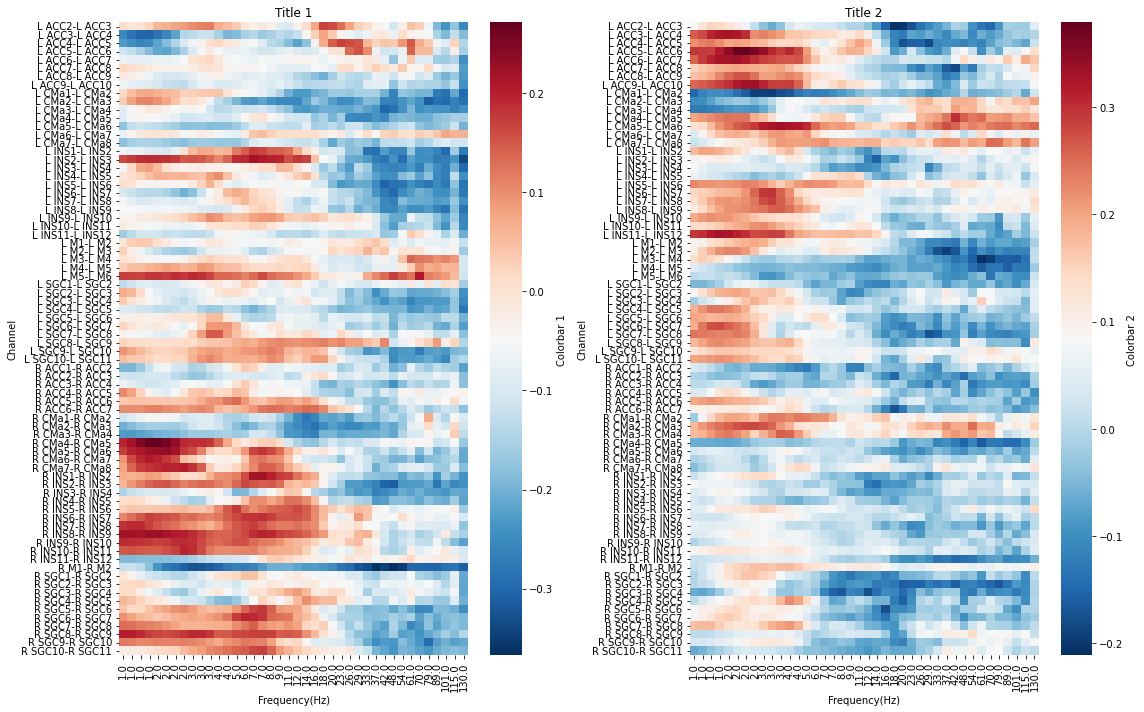

In [185]:
sys.path.append("/home/aallawala/Plotting-GenFxns/")

def basic_heatmap(ax, array, cbar_title, title):
    fig_params = [8, 10]
    caxis_lim = [-0.1, 0.2]
    
    sns.heatmap((array.T), cmap="RdBu_r", cbar=True, 
                yticklabels=ch_labels, xticklabels=np.round(freqs), 
                cbar_kws={'label': cbar_title}, ax=ax)
    ax.set_xlabel("Frequency(Hz)")
    ax.set_ylabel("Channel")
    ax.set_title(title)


def plot_heatmap_subplots(data_list, cbar_titles, titles, nrows, ncols):
    """
    Generate subplots using the custom heatmap function.

    Parameters:
    data_list (list of ndarray): List of 2D arrays to be plotted as heatmaps.
    cbar_titles (list of str): List of colorbar titles for each heatmap.
    titles (list of str): List of titles for each heatmap.
    nrows (int): Number of rows in the subplot grid.
    ncols (int): Number of columns in the subplot grid.
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 10 * nrows))
    axes = axes.flatten() 

    for i, (array, cbar_title, title) in enumerate(zip(data_list, cbar_titles, titles)):
        basic_heatmap(axes[i], array, cbar_title, title)

    plt.tight_layout()
    plt.show()


# Generate some example data


# Plot the heatmaps in a 2x2 grid
plot_heatmap_subplots([corr_vasp, corr_vasd], cbar_titles, titles, nrows=1, ncols=2)






In [175]:
data_list = [np.random.rand(3, 10) for _ in range(4)]  # List of 2D arrays (trials x features)


4

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def heatmap(ax, array, cbar_title, title):
    fig_params = [8, 10]
    caxis_lim = [-0.1, 0.2]
    
    sns.heatmap((array.T), cmap="RdBu_r", cbar=True, 
                yticklabels=ch_labels, xticklabels=np.round(freqs), 
                cbar_kws={'label': cbar_title}, ax=ax)
    ax.set_xlabel("Frequency(Hz)")
    ax.set_ylabel("Channel")
    ax.set_title(title)


def plot_heatmap_subplots(data_list, cbar_titles, titles, nrows, ncols):
    """
    Generate subplots using the custom heatmap function.

    Parameters:
    data_list (list of ndarray): List of 2D arrays to be plotted as heatmaps.
    cbar_titles (list of str): List of colorbar titles for each heatmap.
    titles (list of str): List of titles for each heatmap.
    nrows (int): Number of rows in the subplot grid.
    ncols (int): Number of columns in the subplot grid.
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 10 * nrows))
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    for i, (array, cbar_title, title) in enumerate(zip(data_list, cbar_titles, titles)):
        heatmap(axes[i], array, cbar_title, title)

    plt.tight_layout()
    plt.show()


In [154]:
from scipy import stats, linalg

# Step 1: Fit regression models and obtain residuals
# Regression of Y on Z

Z = vasd_z_clean
Y = vasp_z_clean
X = clean_psd_z.T
slope_YZ, intercept_YZ, _, _, _ = stats.linregress(Z, Y)
Y_pred = slope_YZ * Z + intercept_YZ
Y_resid = Y - Y_pred

# Regression of each feature in X on Z
X_resid = np.zeros_like(X)
for i in range(n_feats):
    slope_XZ, intercept_XZ, _, _, _ = stats.linregress(Z, X[:, i])
    X_pred = slope_XZ * Z + intercept_XZ
    X_resid[:, i] = X[:, i] - X_pred

# Step 2: Compute partial correlation coefficients
partial_corr_XY_Z_reg = np.zeros(n_feats)
for i in range(n_feats):
    partial_corr_XY_Z_reg[i], _ = stats.pearsonr(X_resid[:, i], Y_resid)

print("Partial correlation coefficients between X and Y controlling for Z using regression:")
pcorr_reshaped = partial_corr_XY_Z_reg.reshape(n_freq, n_ch)

Partial correlation coefficients between X and Y controlling for Z using regression:
[0.12279684 0.0822858  0.09401289 ... 0.08929308 0.04214216 0.02040285]
